In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Sat Jun 29 16:47:31 PDT 2024


# Scenario 4: Swapping DAS for 2010 data, TDA DAS for 2020 data

In [2]:
np.random.seed(12345)

# Load synthetic data for TX and use it to simulate 2010 and 2020 populations, and also get k_anon_2020 value from existing demo product



In [3]:
import linked_census_disclosure.data as lcd_data

In [4]:
%%time

sf1 = lcd_data.read_sf1_remf('tx')
dhc = lcd_data.read_dhc_remf('tx')

CPU times: user 18 s, sys: 3.2 s, total: 21.2 s
Wall time: 1min 10s


In [5]:
sf1

,state,county,tract,block,row_num,age,sex,race,eth,n
0,48,201.0,431802.0,2009.0,0,0.0,0.0,0.0,0.0,8.0
1,48,201.0,431802.0,2009.0,1,0.0,0.0,0.0,1.0,3.0
2,48,201.0,431802.0,2009.0,2,0.0,0.0,6.0,0.0,2.0
3,48,201.0,431802.0,2009.0,3,0.0,1.0,0.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...
5941,48,451.0,1600.0,4313.0,0,18.0,1.0,0.0,0.0,2.0
5942,48,337.0,950200.0,1051.0,0,18.0,0.0,0.0,0.0,2.0
5943,48,333.0,950100.0,2208.0,0,18.0,0.0,0.0,0.0,1.0
5944,48,279.0,950600.0,1182.0,0,18.0,0.0,0.0,0.0,1.0


In [6]:
old_dhc = dhc

In [7]:
%%time

ppmf = pd.read_csv('/share/scratch/users/abie/projects/2023/ppmf_production_settings/2023-04-03-ppmf_p.csv')

CPU times: user 4min 15s, sys: 59.5 s, total: 5min 14s
Wall time: 5min 35s


# details on these ppmfs

https://www2.census.gov/programs-surveys/decennial/2020/program-management/data-product-planning/2010-demonstration-data-products/04-Demonstration_Data_Products_Suite/2023-04-03/2023-04-03_Privacy-Protected_Microdata_File/2023-04-03-ppmf-record-layout.pdf

In [8]:
# restructure ppmf data to match reconstructed dhc data that we used previously
t = ppmf[ppmf.TABBLKST == 48].copy()

t['state'] = t.TABBLKST.astype(int)  # ANNOYING: these types need to be just right for my hacky geoids to match up
assert set(t.state.unique()) == set(dhc.state.unique())

t['county'] = t.TABBLKCOU.astype(float)
assert set(t.county.unique()) == set(dhc.county.unique())

In [9]:
# def my_combined_set(df, col_list):
#     return set(
#         sum([df[col].astype(str) for col in col_list]).unique()
#     )


t['tract'] = t.TABTRACTCE.astype(float)
# assert my_combined_set(t, ['county', 'tract']) == my_combined_set(dhc, ['county', 'tract'])
assert set(t.tract.unique()) == set(dhc.tract.unique())

t['block'] = t.TABBLK.astype(float)
# assert my_combined_set(t, ['county', 'tract', 'block']) == my_combined_set(dhc, ['county', 'tract', 'block'])
# assert set(t.block.unique()) == set(dhc.block.unique())

In [10]:
t['age'] = t.QAGE.astype(float)
t['sex'] = (t.QSEX == 2).astype(float) # 2 -> female -> 1.0; 1 -> male -> 0.0
t['race'] = (t.CENRACE - 1) # TODO: confirm that this mapping is correct
t['eth'] = (t.CENHISP == 2).astype(float) # 2 -> Hispanic -> 1.0

In [11]:
t['n'] = 1.0
g = t.groupby(['state', 'county', 'tract', 'block', 'age', 'sex', 'race', 'eth'])

In [12]:
dhc = g.n.sum().reset_index()

In [13]:
dhc

,state,county,tract,block,age,sex,race,eth,n
0,48,1.0,950100.0,1000.0,2.0,1.0,5,1.0,1.0
1,48,1.0,950100.0,1000.0,3.0,0.0,5,1.0,1.0
2,48,1.0,950100.0,1000.0,4.0,1.0,5,1.0,1.0
3,48,1.0,950100.0,1000.0,5.0,1.0,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
11717815,48,507.0,950302.0,5026.0,59.0,0.0,0,0.0,1.0
11717816,48,507.0,950302.0,5026.0,59.0,1.0,0,1.0,1.0
11717817,48,507.0,950302.0,5026.0,64.0,1.0,0,1.0,1.0
11717818,48,507.0,950302.0,5026.0,71.0,0.0,0,1.0,1.0


In [14]:
# does this have the expected number of people? yes, now it does
f'{sf1.n.sum():,.0f}' # expect population of texas in 2010 to be 25,145,561

'25,145,561'

# Focus in on the 10-17 year olds

We will use this group as our 2020 population and then simulate what their attributes were in 2010 for our 2010 population.

In [15]:
sf1[(sf1.age >= 10) & (sf1.age < 18)]

,state,county,tract,block,row_num,age,sex,race,eth,n
42,48,201.0,431802.0,2009.0,42,10.0,0.0,0.0,1.0,1.0
43,48,201.0,431802.0,2009.0,43,10.0,0.0,1.0,0.0,2.0
44,48,201.0,431802.0,2009.0,44,10.0,1.0,0.0,0.0,3.0
45,48,201.0,431802.0,2009.0,45,10.0,1.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...
5925,48,111.0,950100.0,1136.0,3,14.0,0.0,17.0,1.0,1.0
5934,48,387.0,950100.0,2057.0,0,17.0,0.0,1.0,1.0,1.0
5936,48,171.0,950500.0,1125.0,0,10.0,0.0,0.0,1.0,1.0
5937,48,171.0,950500.0,1125.0,1,17.0,1.0,0.0,1.0,1.0


## expand this portion of the SF1 into microdata

For example, turn the first row of the table above into 9 rows for non-Hispanic White males who are age 8 in 2020.

In [16]:
# it takes a while to do this, around 15-30 minutes

In [17]:
%%time

def my_expand(df):
    assert len(df) == 1
    return pd.Series(1, index=range(df.iloc[0].n.astype(int)), name='pweight')

df = sf1[(sf1.age >= 10) & (sf1.age < 18)].groupby(
    ['state', 'county', 'tract', 'block', 'age', 'sex', 'race', 'eth']).apply(my_expand).reset_index()

CPU times: user 43min 32s, sys: 44.5 s, total: 44min 16s
Wall time: 44min 17s


In [18]:
df_all = df.copy()

In [19]:
n_kids = len(df)  # number of children
f'{n_kids:,.0f}'

'3,009,117'

In [20]:
#### simulate 10 years of demographic change

df['age_2020'] = df.age
df['age_2010'] = df.age - 10
del df['age']

In [21]:
assert np.all(df.age_2010 >= 0), 'ensure that all ages are still non-negative'

In [22]:
# ignore births, because we are focused
# only on kids who can be linked between 2010 and 2020 census

# Add in migration, make the change to the 2010 geography

p_stay from ACS, see [2022_04_19a_das_dhc_attack_mig_data.ipynb](2022_04_19a_das_dhc_attack_mig_data.ipynb)

In [23]:
# simple model migration, based on probability
# of being in same house for 10+ years among household with 8-17 year olds
# in ACS

p_stay = 0.23


In [24]:
def add_geoid(df):
    """form geoid from 'state', 'county', 'tract', 'block'
    """

    df['geoid'] = (df.state.astype(str) + df.county.astype(str).str.zfill(3)
                   + df.tract.astype(str).str.zfill(6) + df.block.astype(str).str.zfill(4))
    
add_geoid(sf1)
add_geoid(dhc)
add_geoid(df)

In [25]:
dhc.geoid.value_counts()

4829.0181819.02002.0     707
48201.0542102.02012.0    702
4829.0181404.01002.0     631
4829.0180701.02001.0     629
                        ... 
48285.00400.02075.0        1
4813.0960600.01170.0       1
48177.00600.01081.0        1
48441.013600.02067.0       1
Name: geoid, Length: 458171, dtype: int64

In [26]:
sf1.geoid.value_counts()

48201.0542102.02012.0    133
48201.0542000.01008.0    127
48141.010600.03025.0     126
4829.0181819.02002.0     125
                        ... 
4879.0950100.01361.0       1
4883.0950700.01428.0       1
48503.0950400.03107.0      1
48279.0950600.01182.0      1
Name: geoid, Length: 454658, dtype: int64

In [27]:
all_locations = sf1.geoid
p_all_locations = sf1.n / sf1.n.sum()

In [28]:
locations_2020 = df.geoid

In [29]:
random_location = np.random.choice(all_locations, size=len(df),
                                   p=p_all_locations, replace=True)

locations_2010 = np.where(np.random.uniform(size=len(df)) < p_stay,
                         locations_2020,
                         random_location)

In [30]:
np.mean(locations_2010 == locations_2020)  # should be around 0.23

0.23014824614662707

In [31]:
df['geoid_2020'] = locations_2020
df['geoid_2010'] = locations_2010
del df['geoid']

df

,state,county,tract,block,sex,race,eth,level_8,pweight,age_2020,age_2010,geoid_2020,geoid_2010
0,48,1.0,950100.0,1000.0,0.0,5.0,1.0,0,1,10.0,0.0,481.0950100.01000.0,48185.0180101.03003.0
1,48,1.0,950100.0,1000.0,1.0,5.0,1.0,0,1,11.0,1.0,481.0950100.01000.0,48201.0411800.03023.0
2,48,1.0,950100.0,1000.0,0.0,5.0,1.0,0,1,13.0,3.0,481.0950100.01000.0,481.0950100.01000.0
3,48,1.0,950100.0,1000.0,0.0,1.0,0.0,0,1,15.0,5.0,481.0950100.01000.0,481.0950100.01000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009113,48,507.0,950302.0,5025.0,0.0,0.0,1.0,0,1,13.0,3.0,48507.0950302.05025.0,48135.02900.03007.0
3009114,48,507.0,950302.0,5025.0,1.0,0.0,1.0,0,1,17.0,7.0,48507.0950302.05025.0,48409.010302.02003.0
3009115,48,507.0,950302.0,5026.0,0.0,0.0,1.0,0,1,15.0,5.0,48507.0950302.05026.0,48507.0950302.05026.0
3009116,48,507.0,950302.0,5026.0,0.0,0.0,1.0,0,1,17.0,7.0,48507.0950302.05026.0,4829.0182101.01003.0


In [32]:
np.mean(df.geoid_2010 == df.geoid_2020)  # should be around 23%

0.23014824614662707

# Make gender column, based on BRFSS 2019 SOGI results

In future work, could try to incorporate observation that there is substantial age dependence in these values.  But for now, keep it simple, and work with the crude prevalence rates.  It is already not-that-simple.

Since we want to use the demonstration DHC without re-running it, we first take the reported_sex_2020 column from the `sex` column in the SF1 ReMF (note: this conflates swapping and TDA)

In [33]:
df['reported_sex_2020'] = df.sex

In [34]:
# then initalize a gender for each simulant, calibrated to have unconditional probability from BRFSS
# and also to match the data generation procedure for the reported_sex_2020 column

p_trans_boy = 0.18 / 100
p_trans_girl = 0.22 / 100
p_trans_other = 0.12 / 100
p_cis = 98.08 / 100

# rescale to sum to 100%
p_gender = np.array([p_trans_boy, p_trans_girl, p_trans_other, p_cis])
p_gender /= p_gender.sum()
p_gender

array([0.00182556, 0.00223124, 0.00121704, 0.99472617])

In [35]:
# first initialize gender without distinguishing cis boy and cis girl
# since that matches BRFSS SOGI question
df['gender'] = np.random.choice(['trans_boy', 'trans_girl', 'trans_other', 'cis'], p=p_gender, size=len(df))

In [36]:
# now distinguish cis based on reconstructed sex_id
df.gender = np.where(df.gender == 'cis',
                     df.sex.map({0:'cis_boy', 1:'cis_girl'}),
                     df.gender  # ~50% of trans_boys have reported_sex_2020 female, etc
                    )

In [37]:
df['trans'] = df.gender.isin(['trans_boy', 'trans_girl', 'trans_other'])

In [38]:
np.round(100 * df.gender.value_counts(normalize=True), 2)

cis_boy        50.99
cis_girl       48.48
trans_girl      0.22
trans_boy       0.18
trans_other     0.12
Name: gender, dtype: float64

In [39]:
np.round(100 * df.gender.value_counts(normalize=True).filter(like='trans').sum(), 2)

0.52

In [40]:
np.round(100 * df.trans.mean(), 2)

0.52

In [41]:
df[df.trans].groupby('gender').reported_sex_2020.value_counts(normalize=True).unstack()

reported_sex_2020,0.0,1.0
gender,,
trans_boy,0.497812,0.502188
trans_girl,0.500673,0.499327
trans_other,0.507739,0.492261


In [42]:
def gender_to_sex_2010(gender, reported_sex_2020):
    # start with values reported in 2020
    sex = reported_sex_2020.copy()
    
    # update the trans_boy and trans_girl entries to be sex assigned at birth
    sex = np.where((gender == 'trans_boy'),
                   1,
                   sex
                  )
    sex = np.where((gender == 'trans_girl'),
                   0,
                   sex
                  )
    return sex


df['reported_sex_2010'] = gender_to_sex_2010(df.gender, df.reported_sex_2020)

In [43]:
df['trans'].mean()

0.005247054202279273

In [44]:
np.mean(df.reported_sex_2010 != df.reported_sex_2020)

0.0020168707298519797

# Values for results section

In [45]:
# Our synthetic population matched the age, sex, race/ethnicity, and geography of Texas
# on census day April 1, 2010, with
# X children ages 0-7 in Y household on census day 2010

n_kids = len(df)  # number of children
f'{n_kids:,.0f}'

'3,009,117'

In [46]:
# number of kids that were in same census block in 2010 and 2020 census
n_stayed = (df.geoid_2010 == df.geoid_2020).sum()
f'{n_stayed:,.0f}'

'692,543'

In [47]:
# number of trans kids that were in same place in 2010 and 2020 census

n_trans_stayed = (df.trans & (df.geoid_2010 == df.geoid_2020)).sum()
f'{n_trans_stayed:,.0f}'

'3,629'

In [48]:
# number of trans kids identified if full census data with names and dob was released

n_trans = df[(df.reported_sex_2010 != df.reported_sex_2020)].pweight.sum()
f'{n_trans:,.0f}'

'6,069'

# number of trans families identified by age, geoid from reconstruction based on TDA-protected DHC


In [49]:
# without reidentification to link on, there is still a risk of identifying a block with a trans kid
# by finding blocks where there was a single kids of a given age in 2010 and that age+10 in 2020 and
# different reported sex
df['reported_male_2010'] = (df.reported_sex_2010 == 0)
df['geoid'] = df.geoid_2010
df['age'] = df.age_2010 + 10 # add ten to make merge easier
g = df.groupby(['geoid', 'age',
                'race', 'eth'])

df_a = pd.DataFrame({'n_simulants': g.pweight.sum()})
df_a['pct_male'] = 100*g.reported_male_2010.mean()
df_a['pct_trans'] = 100*g.trans.mean()
df_a

n_simulants  pct_male  pct_trans
geoid                age  race eth                                  
481.0950100.01000.0  11.0 0.0  1.0            1       0.0        0.0
                     13.0 0.0  0.0            1       0.0        0.0
                          5.0  1.0            2      50.0        0.0
                     15.0 1.0  0.0            2      50.0        0.0
...                                         ...       ...        ...
4899.010804.03032.0  13.0 1.0  0.0            1     100.0        0.0
4899.010804.03034.0  12.0 7.0  0.0            1     100.0        0.0
                     13.0 0.0  0.0            2       0.0        0.0
4899.0980000.01211.0 13.0 0.0  1.0            1     100.0        0.0

[2204887 rows x 3 columns]

In [50]:
df['reported_male_2020'] = (df.reported_sex_2020 == 0)
df['geoid'] = df.geoid_2020
df['age'] = df.age_2020
df['discordant_sex'] = (df.reported_sex_2010 != df.reported_sex_2020)

g = df.groupby(['geoid', 'age',
                'race', 'eth'])

df_b = pd.DataFrame({'n_simulants': g.pweight.sum()})
df_b['pct_male'] = 100*g.reported_male_2020.mean()
df_b['pct_trans'] = 100*g.trans.mean()
df_b['pct_discordant_sex'] = 100*g.discordant_sex.mean()
n_unique_2020 = sum(df_b.n_simulants == 1)
n_unique_2020

1239637

In [51]:
dhc

,state,county,tract,block,age,sex,race,eth,n,geoid
0,48,1.0,950100.0,1000.0,2.0,1.0,5,1.0,1.0,481.0950100.01000.0
1,48,1.0,950100.0,1000.0,3.0,0.0,5,1.0,1.0,481.0950100.01000.0
2,48,1.0,950100.0,1000.0,4.0,1.0,5,1.0,1.0,481.0950100.01000.0
3,48,1.0,950100.0,1000.0,5.0,1.0,0,0.0,1.0,481.0950100.01000.0
...,...,...,...,...,...,...,...,...,...,...
11717815,48,507.0,950302.0,5026.0,59.0,0.0,0,0.0,1.0,48507.0950302.05026.0
11717816,48,507.0,950302.0,5026.0,59.0,1.0,0,1.0,1.0,48507.0950302.05026.0
11717817,48,507.0,950302.0,5026.0,64.0,1.0,0,1.0,1.0,48507.0950302.05026.0
11717818,48,507.0,950302.0,5026.0,71.0,0.0,0,1.0,1.0,48507.0950302.05026.0


In [52]:
dhc['male'] = (dhc.sex == 0)
# dhc['male'] = (np.random.uniform(size=len(dhc)) < 0.5) # a) Take the actual DHC, ignore the sex attributes, generate sex randomly, and use that as the "DHC" in the simulation.
g = dhc.groupby(['geoid', 'age', 'race', 'eth'])
df_c = pd.DataFrame({'n_simulants':g.n.sum()})
df_c['pct_male'] = 100 * g.male.mean()

In [53]:
df_c

n_simulants  pct_male
geoid                age  race eth                       
481.0950100.01000.0  2.0  5    1.0          1.0       0.0
                     3.0  5    1.0          1.0     100.0
                     4.0  5    1.0          1.0       0.0
                     5.0  0    0.0          1.0       0.0
...                                         ...       ...
4899.0980000.01428.0 58.0 0    0.0          1.0     100.0
                     63.0 0    0.0          1.0     100.0
                     73.0 0    0.0          1.0       0.0
4899.0980000.01538.0 14.0 9    0.0          1.0       0.0

[10811822 rows x 2 columns]

In [54]:
df_abc = df_a[df_a.n_simulants==1].copy()
df_abc.columns = ['n_simulants_2010', 'pct_male_2010', 'pct_trans_2010']

df_abc['n_simulants_2020'] = df_c[df_c.n_simulants==1].n_simulants
df_abc['pct_male_2020'] = df_c[df_c.n_simulants==1].pct_male
df_abc = df_abc.dropna()

df_abc['pct_trans_2020'] = df_b.pct_trans
df_abc['pct_discordant_sex'] = df_b.pct_discordant_sex
df_abc

n_simulants_2010  pct_male_2010  \
geoid               age  race eth                                    
481.0950100.01022.0 11.0 0.0  0.0                 1            0.0   
481.0950100.01073.0 11.0 0.0  0.0                 1            0.0   
                    13.0 0.0  0.0                 1            0.0   
                    17.0 0.0  0.0                 1          100.0   
...                                             ...            ...   
4899.010804.03018.0 16.0 0.0  0.0                 1            0.0   
                         5.0  1.0                 1            0.0   
4899.010804.03019.0 16.0 0.0  0.0                 1          100.0   
4899.010804.03030.0 11.0 0.0  0.0                 1          100.0   

                                   pct_trans_2010  n_simulants_2020  \
geoid               age  race eth                                     
481.0950100.01022.0 11.0 0.0  0.0             0.0               1.0   
481.0950100.01073.0 11.0 0.0  0.0             0.0               1.0   
                    13.0 0.0  0.0             0.0               1.0   
                    17.0 0.0  0.0             0.0               1.0   
...                                           ...               ...   
4899.010804.03018.0 16.0 0.0  0.0             0.0               1.0   
                         5.0  1.0             0.0               1.0   
4899.010804.03019.0 16.0 0.0  0.0             0.0               1.0   
4899.010804.03030.0 11.0 0.0  0.0             0.0               1.0   

                                   pct_male_2020  pct_trans_2020  \
geoid               age  race eth                                  
481.0950100.01022.0 11.0 0.0  0.0            0.0             0.0   
481.0950100.01073.0 11.0 0.0  0.0          100.0             0.0   
                    13.0 0.0  0.0            0.0             NaN   
                    17.0 0.0  0.0            0.0             0.0   
...                                          ...             ...   
4899.010804.03018.0 16.0 0.0  0.0          100.0             NaN   
                         5.0  1.0          100.0             NaN   
4899.010804.03019.0 16.0 0.0  0.0          100.0             NaN   
4899.010804.03030.0 11.0 0.0  0.0          100.0             0.0   

                                   pct_discordant_sex  
geoid               age  race eth                      
481.0950100.01022.0 11.0 0.0  0.0                 0.0  
481.0950100.01073.0 11.0 0.0  0.0                 0.0  
                    13.0 0.0  0.0                 NaN  
                    17.0 0.0  0.0                 0.0  
...                                               ...  
4899.010804.03018.0 16.0 0.0  0.0                 NaN  
                         5.0  1.0                 NaN  
4899.010804.03019.0 16.0 0.0  0.0                 NaN  
4899.010804.03030.0 11.0 0.0  0.0                 0.0  

[94429 rows x 7 columns]

In [55]:
df_abc.dropna(subset=['n_simulants_2010'])

n_simulants_2010  pct_male_2010  \
geoid               age  race eth                                    
481.0950100.01022.0 11.0 0.0  0.0                 1            0.0   
481.0950100.01073.0 11.0 0.0  0.0                 1            0.0   
                    13.0 0.0  0.0                 1            0.0   
                    17.0 0.0  0.0                 1          100.0   
...                                             ...            ...   
4899.010804.03018.0 16.0 0.0  0.0                 1            0.0   
                         5.0  1.0                 1            0.0   
4899.010804.03019.0 16.0 0.0  0.0                 1          100.0   
4899.010804.03030.0 11.0 0.0  0.0                 1          100.0   

                                   pct_trans_2010  n_simulants_2020  \
geoid               age  race eth                                     
481.0950100.01022.0 11.0 0.0  0.0             0.0               1.0   
481.0950100.01073.0 11.0 0.0  0.0             0.0               1.0   
                    13.0 0.0  0.0             0.0               1.0   
                    17.0 0.0  0.0             0.0               1.0   
...                                           ...               ...   
4899.010804.03018.0 16.0 0.0  0.0             0.0               1.0   
                         5.0  1.0             0.0               1.0   
4899.010804.03019.0 16.0 0.0  0.0             0.0               1.0   
4899.010804.03030.0 11.0 0.0  0.0             0.0               1.0   

                                   pct_male_2020  pct_trans_2020  \
geoid               age  race eth                                  
481.0950100.01022.0 11.0 0.0  0.0            0.0             0.0   
481.0950100.01073.0 11.0 0.0  0.0          100.0             0.0   
                    13.0 0.0  0.0            0.0             NaN   
                    17.0 0.0  0.0            0.0             0.0   
...                                          ...             ...   
4899.010804.03018.0 16.0 0.0  0.0          100.0             NaN   
                         5.0  1.0          100.0             NaN   
4899.010804.03019.0 16.0 0.0  0.0          100.0             NaN   
4899.010804.03030.0 11.0 0.0  0.0          100.0             0.0   

                                   pct_discordant_sex  
geoid               age  race eth                      
481.0950100.01022.0 11.0 0.0  0.0                 0.0  
481.0950100.01073.0 11.0 0.0  0.0                 0.0  
                    13.0 0.0  0.0                 NaN  
                    17.0 0.0  0.0                 0.0  
...                                               ...  
4899.010804.03018.0 16.0 0.0  0.0                 NaN  
                         5.0  1.0                 NaN  
4899.010804.03019.0 16.0 0.0  0.0                 NaN  
4899.010804.03030.0 11.0 0.0  0.0                 0.0  

[94429 rows x 7 columns]

In [56]:
df_abc[df_abc.pct_male_2010 != df_abc.pct_male_2020].pct_trans_2020.value_counts(dropna=False)

0.000000      22982
NaN           22616
100.000000       69
50.000000        68
              ...  
20.000000        11
12.500000         3
16.666667         2
14.285714         2
Name: pct_trans_2020, Length: 10, dtype: int64

In [57]:
df_abc[df_abc.pct_male_2010 != df_abc.pct_male_2020].pct_discordant_sex.value_counts(dropna=False)

0.000000      23096
NaN           22616
50.000000        29
100.000000       25
              ...  
20.000000         5
14.285714         2
12.500000         2
16.666667         1
Name: pct_discordant_sex, Length: 10, dtype: int64

In [58]:
n_scenario_4 = sum(
    df_abc[df_abc.pct_male_2010 != df_abc.pct_male_2020].pct_trans_2020 > 0
    )
N_scenario_4 = sum(df_abc.pct_male_2010 != df_abc.pct_male_2020)

In [59]:
n_scenario_4, N_scenario_4-n_scenario_4

(194, 45598)

In [60]:
n_scenario_4 / N_scenario_4

0.00423654786862334

In [61]:
# what is the rate of identifying trans kids if you just pick strata at random
t = df.groupby(['geoid', 'age',
                'race', 'eth']).discordant_sex.mean()
(t>0).mean()

0.0033665635091421433

In [62]:
# HACK to avoid re-running all
n_scenario_4 = 194

In [63]:
n_scenario_3 = 283
100 * (n_scenario_3 - n_scenario_4) / n_scenario_3  # pct decrease from scenario 3 to 4

31.448763250883392

# Double check that I mapped race correctly

And might as well check the coding of sex and ethnicity while I'm at it.

In [64]:
s_dhc_race = dhc.groupby('race').n.sum()
s_sf1_race = df_all.groupby('race').pweight.sum()
t = pd.DataFrame({'dhc': s_dhc_race,
                 'sf1': s_sf1_race,})
t

,dhc,sf1
race,,
0.0,17701558.0,1994695
1.0,2979629.0,390564
2.0,170962.0,23603
3.0,964608.0,99794
...,...,...
59.0,8.0,43
60.0,16.0,34
61.0,2.0,25
62.0,92.0,19


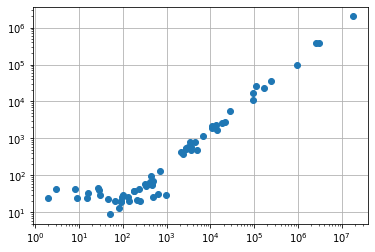

In [65]:
plt.loglog(t.dhc, t.sf1, 'o')
plt.grid();

In [66]:
def my_compare(col):
    s_dhc = dhc.groupby(col).n.sum()
    s_sf1 = df_all.groupby(col).pweight.sum()
    t = pd.DataFrame({'dhc': s_dhc,
                     'sf1': s_sf1,})
    t['ratio'] = t.sf1 / t.dhc
    return t
my_compare('eth')

,dhc,sf1,ratio
eth,,,
0.0,15684656.0,1615133,0.102975
1.0,9460905.0,1393984,0.147342


In [67]:
my_compare('sex')

,dhc,sf1,ratio
sex,,,
0.0,12471657.0,1542286,0.123663
1.0,12673904.0,1466831,0.115736
